In [18]:
import pandas as pd
import data_util
from tqdm import tqdm_notebook as tqdm
from data_generator import DataGenerator
from state_util import StateUtil
from tec_an import TecAn
from data_agent import DataAgent, TacProcess
import numpy as np
from data_util import *
import tensorflow as tf
from sklearn_model_hyper import *
import pandas as pd
from stock_agent import *


In [29]:
def get_y_data(ohlc, shift = -1):
    combined_data = ohlc
    #combined_data['return'] = np.log(combined_data / combined_data.shift(1))
    returns = (ohlc / ohlc.shift(shift))
    combined_data['return'] = returns
    combined_data['direction'] = np.where(combined_data['return'] < 1, 1, 0)
    #print(combined_data)
    #combined_data.dropna(inplace=True)
    #print(combined_data[20:40])
    return combined_data['direction']

def split(x, y, split, shuffle=False):
    trainX, valX, trainY, valY = train_test_split(np.array(x), np.array(y), test_size=split, shuffle=shuffle)
    print("Completed: {} {} {} {}".format(trainX.shape, trainY.shape, valX.shape, valY.shape))
    return trainX, trainY, valX, valY


def get_full_database(resample, raw_dir, base_dir = "data/"):

    full_data = base_dir + raw_dir + "/"
    data_gen = DataGenerator(random = False, base_dir = full_data)
    data_gen.rewind()
    data_count = (data_gen.steps - 100)
    data_count = 200000

    final_x = []

    closed_prices = []

    on_new_data = lambda x: final_x.append(x)
    on_closed_price = lambda price: closed_prices.append(price)
    
    agent = DataAgent(
        resample = resample,
        on_new_data = on_new_data,
        on_closed_price = on_closed_price
    )

    print("Processing {}".format(raw_dir))

    for i in tqdm(range(data_count)):
        agent.on_new_raw_data(data_gen.next())


    closes = pd.DataFrame(closed_prices, columns = ['Close'])

    final_y = get_y_data(closes, -1)
    
    #print(agent.ohlc)
    
    return final_x, final_y.to_numpy(), closed_prices

In [30]:
#data_gen = DataGenerator(random=False, base_dir = "data/4jul21/")

data_gen = DataGenerator(random=False, base_dir = "data/backtest/")

#data_gen = DataGenerator(random=False, base_dir = "data/btcusd/")

data_gen.rewind()


In [31]:
from joblib import dump, load

#models = [
#    load('model/StackingClassifier'), 
#]

#print(f"{len(models)}")

In [32]:

x, y, closed_prices = get_full_database('2Min', "backtest", base_dir = "data/")

len(x)

Resample 2Min - TecAn ( windows 20, windows_limit 100 )
Processing backtest


<ipython-input-29-d4477ab9176c>:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(data_count)):


  0%|          | 0/200000 [00:00<?, ?it/s]

174

In [33]:
back = BackTest(value = 100, verbose = False)
for idx in range(len(x)):
    yy = y[idx]
    price = closed_prices[idx]
    #print(f'{idx} {yy} {price}')
    back.on_state(0, price)
    if(yy == 1):
        back.request_buy(price)
    else:
        back.request_sell(price)


In [34]:
back.report()

100
116.95412572040279
116.95412572040279


In [35]:
data_count = data_gen.steps
data_count = 200000 
data_gen.rewind()

raw_data = []

for i in tqdm(range(data_count)):
    raw_data.append(data_gen.next())

<ipython-input-35-8b99b3dd3ef4>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(data_count)):


  0%|          | 0/200000 [00:00<?, ?it/s]

In [36]:
def process_model(model, resample):
    back = BackTest(value = 100)

    request_sell = lambda price: back.request_sell(price)
    request_buy = lambda price: back.request_buy(price)
    on_state = lambda timestamp, price: back.on_state(timestamp, price)

    stock = StockAgent(model = model,
                    request_sell = request_sell,
                    request_buy = request_buy,
                    on_state = on_state
                      )


    data_gen.rewind()
    back.reset()

    on_new_data = lambda x: print(x)
    on_new_data = lambda x: stock.on_x(x)

    on_state = lambda timestamp, price, bid, ask: print("{} {} {} {}".format(timestamp, price, bid[-1], ask[-1]))
    on_state = lambda timestamp, price, bid, ask: stock.on_new_state(timestamp, price, bid, ask)


    agent = DataAgent(
        resample = resample,
        on_state = on_state,
        on_new_data = on_new_data
    )

    on_new_data_count = 0

    for raw in tqdm(raw_data):
        agent.on_new_raw_data(raw)

    if (back.bought):
        stock.sell()

    (agent.ohlc).plot(figsize=(20, 12))
        
    return back

In [37]:
class ModelTest():
    
    def __init__(self,
                 resample = '2Min'
                 ):
        self.index = 0
        
    def predict(self, x):
        yy = y[self.index]
        self.index += 1
        return [yy]

Resample 2Min - TecAn ( windows 20, windows_limit 100 )


<ipython-input-36-23b3d903de1a>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for raw in tqdm(raw_data):


  0%|          | 0/200000 [00:00<?, ?it/s]

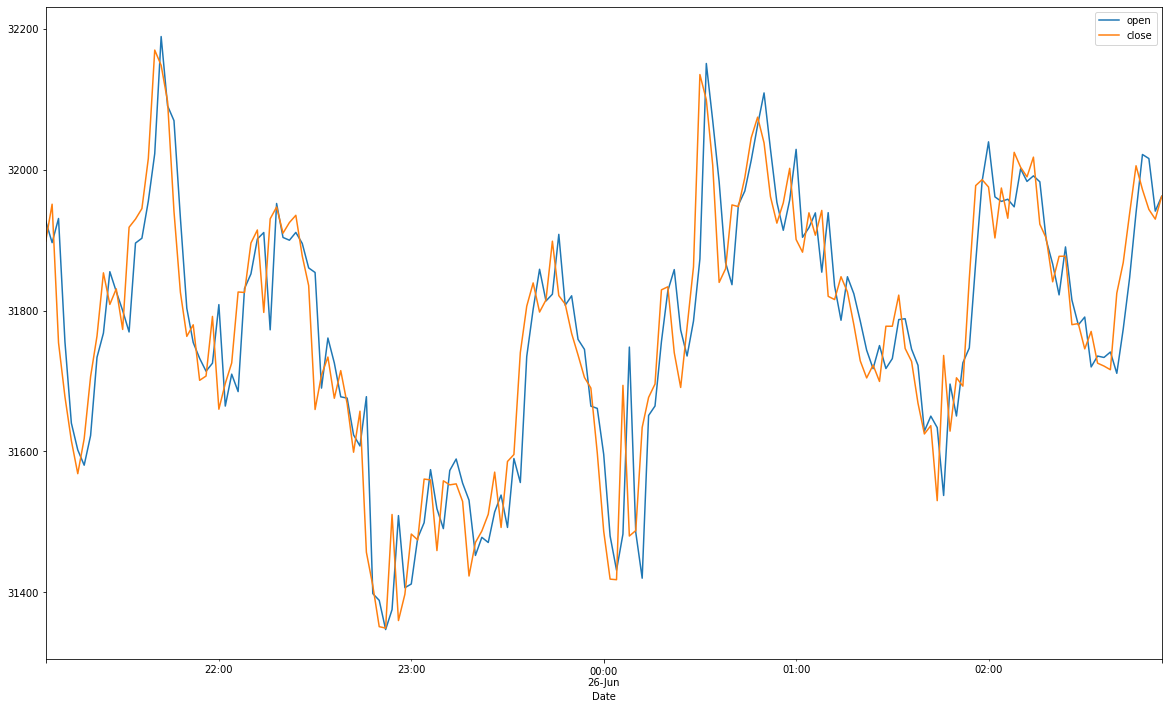

In [39]:
model = ModelTest()
backProc = process_model(model, '2Min')

In [40]:
backProc.report()

100
116.95412572040279
116.95412572040279
